Exploring Decision Trees
========================

Use a decision tree classifier to create a simplified model exploring the "Sex", "Age" and "Fare Per Person" features.

In [45]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.tree as tr
import sklearn.model_selection as mds
import matplotlib.pyplot as plt

datestamp = "20250129.150949"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 21)


In [46]:
#df_[ ((df_["TitleOrd"] == 1) & (df_["Age"].isna())) ].info()

In [47]:
x_colnames = [ "Pclass", "SexOrd", "AgeImputed", "Fare", "GroupSize" ]
#x_colnames = ["AgeImputed", "Pclass"]
y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   SexOrd      891 non-null    float64
 2   AgeImputed  891 non-null    float64
 3   Fare        891 non-null    float64
 4   GroupSize   891 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 34.9 KB
None


In [48]:
n_folds = 6
s_scoring = "balanced_accuracy"

param_dist = {
    'max_leaf_nodes': [ 6 ],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [ 100 ],
    'min_samples_leaf': [ 30, 40, 50, 60]
} 


# Create a decision tree classifier
clf = tr.DecisionTreeClassifier()

grid_search = mds.GridSearchCV( estimator=clf,
                                param_grid=param_dist,
                                cv=n_folds,
                                scoring=s_scoring,
                                n_jobs=-1 )

# Train the classifier
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model       = grid_search.best_estimator_

print(best_params)
print()

{'max_depth': 2, 'max_leaf_nodes': 6, 'min_samples_leaf': 30, 'min_samples_split': 100}



In [49]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)

      Feature  Gini Importance
1      SexOrd          0.77291
0      Pclass          0.14263
2  AgeImputed          0.08446
3        Fare          0.00000
4   GroupSize          0.00000


In [50]:
print(tr.export_text(model, show_weights=True, feature_names=x_colnames, class_names=['Dead', 'Alive']))

|--- SexOrd <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- weights: [7.00, 133.00] class: Alive
|   |--- Pclass >  2.50
|   |   |--- weights: [50.00, 59.00] class: Alive
|--- SexOrd >  0.50
|   |--- AgeImputed <= 9.50
|   |   |--- weights: [12.00, 19.00] class: Alive
|   |--- AgeImputed >  9.50
|   |   |--- weights: [365.00, 67.00] class: Dead



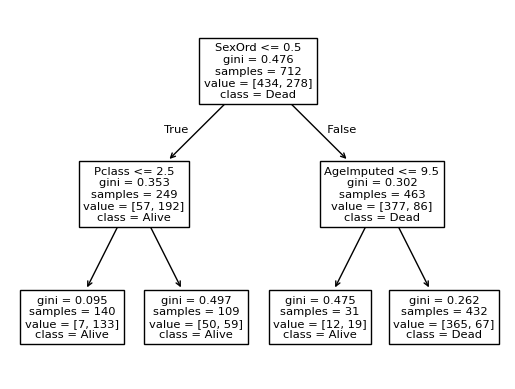

In [51]:
tr.plot_tree(model, feature_names=x_colnames, class_names=['Dead', 'Alive'])
plt.show()

In [52]:
l_raw_scores = mds.cross_val_score(model, X_test, y_test, scoring=s_scoring, cv=n_folds)
l_scores = [ round(i, 2) for i in l_raw_scores ]

mean_score = round(st.mean(l_scores), 3)
std_score = round(st.stdev(l_scores), 3)

print(f"{n_folds}-fold {s_scoring} mean: {mean_score}, stdev: {std_score}")
print(f"  each: {l_scores}")

6-fold balanced_accuracy mean: 0.712, stdev: 0.099
  each: [np.float64(0.62), np.float64(0.67), np.float64(0.71), np.float64(0.72), np.float64(0.9), np.float64(0.65)]


In [53]:
threshold_tuner = mds.TunedThresholdClassifierCV(
    clf, scoring="f1_micro", cv=n_folds).fit(X_train, y_train)
threshold = threshold_tuner.best_threshold_

print(f"Threshold classfier score: {round(threshold_tuner.best_score_,2)}")
print()

Threshold classfier score: 0.78



In [54]:
y_test_preds_proba = model.predict_proba(X_test)
y_test_preds = (y_test_preds_proba[:,1] > threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

Confusion Matrix, at Threshold 0.253
  tn 88   fp 27 
  fn 21   tp 43 



In [55]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/test.submit.{datestamp}.csv", index=False)